# StackGP.fitness
```{python}
StackGP.fitness(model,inputData,response)
```

`fitness` is a StackGP function that computes the $1-r^2$ for a GP model. This is the default accuracy measure used in search. 

The function expects 3 arguments: _model_, _inputData_, and _response_

The arguments are described below: 

* **model**: A StackGP model. 
* **inputData**: A numpy array containing the input data used to evaluate the model.
* **response**: The ground truth response to compare the model's response to.

---

First we need to load in the necessary packages

In [1]:
import StackGP as sgp
import numpy as np

## Overview

### Computing fitness for a random model

Here we generate a random model with up to 4 variables, the default operator set, the default constant set, and a maxSize of 10. 

In [4]:
randomModel=sgp.generateRandomModel(4, sgp.defaultOps(), sgp.defaultConst(), 10)

We can display the random model below

In [5]:
sgp.printGPModel(randomModel)

2.02581370493437*(-0.70258722293364*x0 - 0.70258722293364*x3 - 1)**2 - 5.71828182845904

Now we generate a random input dataset and a ground truth response vector. 

In [6]:
inputData = np.random.rand(4, 100) 
response = np.sin(inputData[0]) + np.cos(inputData[1]) + inputData[2]**2 - inputData[3]**3

Now we can compute the RMSE between the model's response and the ground truth response. 

In [7]:
sgp.fitness(randomModel, inputData, response)

0.9996068366284323

---
---

## Examples

This section provides some interesting examples to demonstrate how `fitness` can be used. 

---

### Checking error of best evolved model
Likely, we are interested in determining the quality of the best model evolved on a test set. 

Lets start by generating a training and test set with 4 features. 

In [8]:
trainInputData = np.random.rand(4, 100)
trainResponse = 5*trainInputData[0] + 2*trainInputData[1] + trainInputData[2]**2
testInputData = np.random.rand(4, 100)
testResponse = 5*testInputData[0] + 2*testInputData[1] + testInputData[2]**2

Now lets evolve a model population using the training data. 

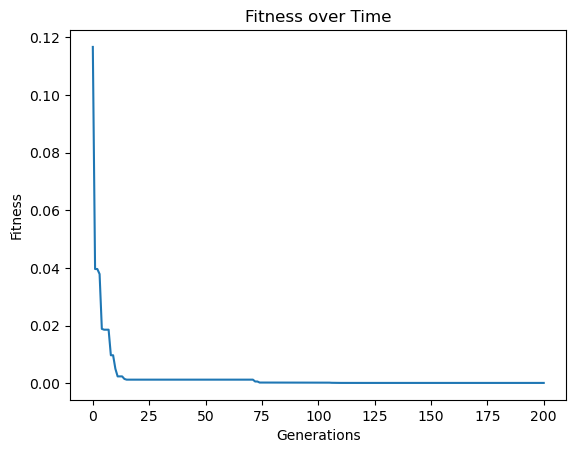

In [9]:
models=sgp.evolve(trainInputData, trainResponse, tracking=True, generations=200, elitismRate=10, tourneySize=30)

Now lets pick the best model evolved from the population. 

In [10]:
bestModel = models[0]
sgp.printGPModel(bestModel)

5.01025360413344*x0 + 1.99447659663629*x1 + 1.63393325099573*sqrt(exp(x2**2)) - 1.61881544923791

Now lets evaluate the fitness of the best model on the test set.

In [11]:
sgp.fitness(bestModel, testInputData, testResponse)

0.00014515275259152638

We can compare that to the fitness on the training set to see if we were overfitting the training or performing similarly on both sets. 

In [12]:
sgp.fitness(bestModel, trainInputData, trainResponse)

0.00013148639667670547

### Using `fitness` as a Fitness Objective

$1-r^2$ is the default fitness function and is used as the accuracy objective in search. Here we demonstrate how we can use just `fitness` rather than the default of using `fitness` and `stackGPModelComplexity`. This converts the search to a 1D problem rather than a 2D optimization problem. 

We will use a randomly generated model to generate the response. So we start with generating a random model. 

In [16]:
randomModel=sgp.generateRandomModel(4, sgp.defaultOps(), sgp.defaultConst(), 20)
sgp.printGPModel(randomModel)

exp(-9.39861563290544/x1)

Now we can generate some data and use the above random model to generate the response from the random input data. 

In [17]:
inputData = np.random.rand(4, 100)
response = sgp.evaluateGPModel(randomModel, inputData)

Now we can evolve models to fit the generated training data. We will set just `fitness` as the fitness objective rather than `stackGPModelComplexity` and `fitness`. 

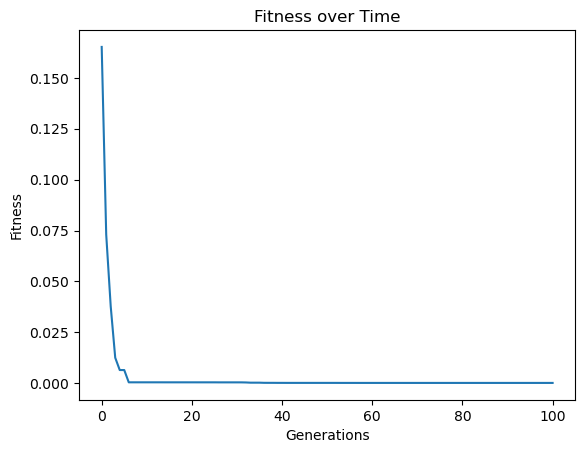

In [18]:
models = sgp.evolve(inputData,response, tracking=True, modelEvaluationMetrics=[sgp.fitness])

Now we can look at the best model generated. 

In [19]:
sgp.printGPModel(models[0])

9.62143970076573e-5*x1**10 - 9.62143970076573e-5*exp(0.00987976710843726/(1 - 0.0993970176033329*exp(2*x1))**2) + 9.76969226624036e-5

Now we can check how well it generalizes to test data. First we need to generate the test data. 

In [20]:
testInputData = np.random.rand(4, 100)
testResponse = sgp.evaluateGPModel(randomModel, testInputData)

Now we can compute the fitness on the test data. 

In [21]:
sgp.fitness(models[0], testInputData, testResponse)

9.710930943729323e-05

We can also visualize the quality of predictions on the test data. 

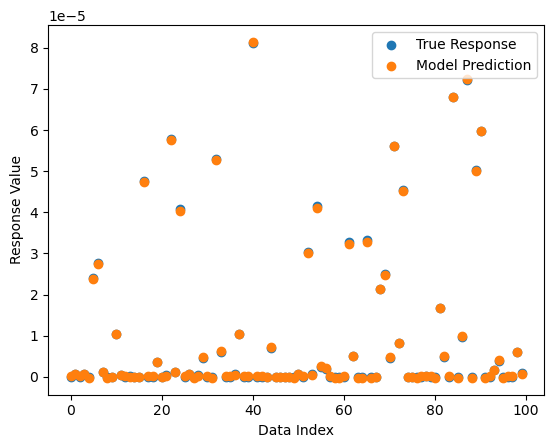

In [22]:
sgp.plotModelResponseComparison(models[0], testInputData, testResponse)

To make it easier to see how close the values are to the test values, we can visualize the residual plot. 

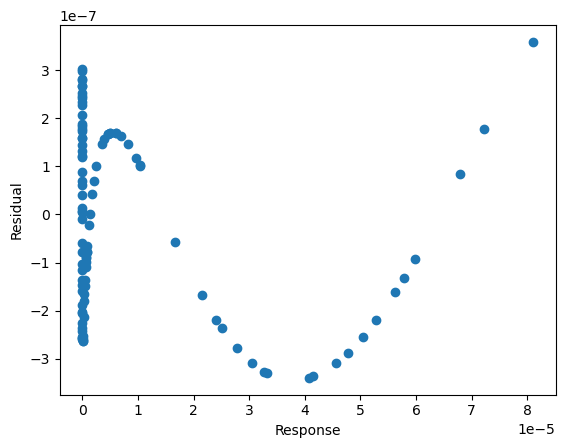

In [23]:
sgp.plotModelResiduals(models[0], testInputData, testResponse)

### Updating Embedded Objectives in Evolved Model

We may be interested in updating the embedded fitness values in a model using a new set of data for analysis. We can easily do this with the `setModelQuality` function. 

First we need to generate some models and data. 

In [24]:
inputData = np.random.rand(5, 100)
randomModel = sgp.generateRandomModel(5, sgp.defaultOps(), sgp.defaultConst(), 20)
response = sgp.evaluateGPModel(randomModel, inputData)
sgp.printGPModel(randomModel)

exp(exp(3.14159265358979*sqrt((1 - 0.318309886183791*x1)**2)))

Now lets train a model using the standard search objectives. 

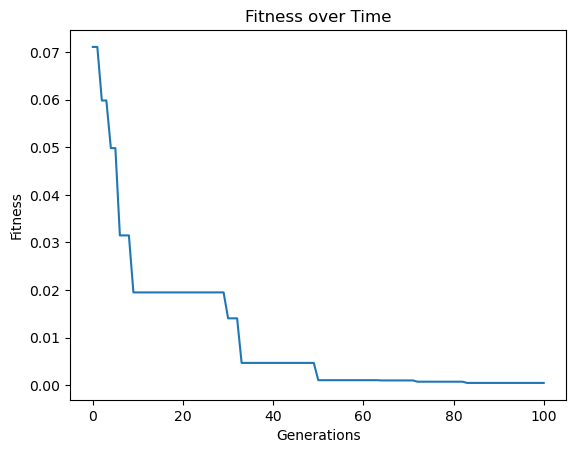

In [25]:
models = sgp.evolve(inputData, response, tracking=True)

Now we can generate a test set. 

In [26]:
testInputData = np.random.rand(5, 100)
testResponse = sgp.evaluateGPModel(randomModel, testInputData)

Now we can upate the model embedded model quality objectives to include $1-r^2$ with respect to the test set. 

In [27]:
for model in models: 
    sgp.setModelQuality(model, testInputData, testResponse, [sgp.fitness])

Now we can look at the fitness vector of a model and we can see it contains 1 value ($1-r^2$).

In [28]:
display(sgp.printGPModel(models[0]))
print("Fitness vector: ", models[0][-1])

10060532.5698567 + 1.47269743762274e+19*exp(-21.0257011904559*exp(x1))

Fitness vector:  [0.0004399535860304393]
